 **This is the lab assignment for ENPM 690 Spring 2022. Please do not distribute this collab file without permission.**

Created on Fri Mar 28 16:58:59 2022

@author: Ruiqi


Import required packages

If you prefer to use your own complier, those are the things you probably need to do:

- You could download and install pytorch from https://pytorch.org/

- Other packages could be installed via pip or conda.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch import nn
from torch.autograd import Variable
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random
import os
import glob
import time
import pickle

You could download the LFW dataset using the following command:

    wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
    tar -xvzf lfw.tgz
    find lfw -iname "*jpg" > images_list.txt

You could also directly download and process the data using torchvision.
Please check:
  1. https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPeople.html
  2. https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPairs.html
  
If you directly use pytorch to download and process the data, then you would
not need to implement the following processes.


If you use the command lines to download the datasets, you will have a
dataset folder named lfw and a txt file with lines format as:

  lfw/Allan_Wagner/

  lfw/Allan_Wagner/Allen_Wagner_0001.jpg

  lfw/Alejandro_Fernandez/

  lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg

  ...


In [5]:
# ! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# ! tar -xvzf lfw.tgz
# ! find lfw -iname "*jpg" > images_list.txt

In [6]:
dataset_path = "lfw"
files = glob.glob(dataset_path + "\**\*.jpg", recursive = True)
with open("images_list.txt", "w") as f:
    for file in files:
        f.write(file + '\n')

**Pre-pocess data**

400 persons are in the test set and 400 persons are included in the
validation set. The remainings are used for training.

In [7]:
images_dict = {}
count = 0
for line in open("images_list.txt","r"):
    line = line.strip()
    person = line.split("\\")[-2]
    if person not in images_dict:
        images_dict[person] = [line]
    else:
        images_dict[person].append(line)
    count += 1

print("Number of unique persons = ", str(len(images_dict)))
print("NUmber of total images = ", str(count))
unique_ids = list(images_dict.keys())
val_ids = unique_ids[-800:-400]
test_ids = unique_ids[-400:]
train_ids = unique_ids[:-800]

Number of unique persons =  5749
NUmber of total images =  13233


Defining pytorch dataset class with return paired data (2 faces) and a label
(0 or 1) which verify if the faces belong to the same person or not.

In [8]:
class LFW_dataset(torch.utils.data.Dataset):

  def __init__(self, split="train", images_dict=images_dict, ids=train_ids, size=(150,150), transform=None):
    self.split = split
    self.images_dict = images_dict
    self.ids = ids
    self.size = size
    self.transform = transform

  def __getitem__(self, index):
    id1 = self.ids[index]
    if len(self.images_dict[id1]) == 1:
      id2 = np.random.randint(0, len(self.ids))
      id2 = self.ids[id2]
      label = 0
    else:
      id2 = id1
      label = 1
    img1 = Image.open(self.images_dict[id1][0]).convert('L').resize(self.size)
    img2 = Image.open(random.sample(self.images_dict[id2], 1)[0]).convert('L').resize(self.size)
    
    if label == 0:
      label = torch.from_numpy(np.array([0.0], dtype=np.float32))
    else:
      label = torch.from_numpy(np.array([1.0], dtype=np.float32))
    
    if self.transform:
        img1 = self.transform(img1)
        img2 = self.transform(img2)
    
    return img1, img2, label

  def __len__(self):
    return len(self.ids)

Define pytorch dataloaders

In [9]:
batch_size = 64
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = LFW_dataset(split="train", images_dict=images_dict, ids=train_ids,transform=transform)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

val_dataset = LFW_dataset(split="validation", images_dict=images_dict, ids=val_ids,transform=transform)
val_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = LFW_dataset(split="test", images_dict=images_dict, ids=test_ids, transform=transform)
test_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# ** You need to fill out the following code to build up your own model and define your training, testing and main functions. Please do not directly use the models that stored in pytorch. You have to build your own model. Specifically, you need to define a network class with your network architecture.**

**If you are new to pytroch, you could find tutorials on https://pytorch.org/tutorials/**

Define your network architecture here (5 points): 

(Hint: you need to decide what type of network you would like to use first. If it is a CNN, then you need to define convolutional layers and fully-connected layers in the init function, and activation layers in the forward function. Please remember, your network only need to have two output: 0 or 1.)

You could use a small network model first, to see if your code works or not. Otherwise, you may waste a lot of time on training.

In [10]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        
        # Hack to find the shape to input to flatten layer
        with torch.no_grad():
            dummy = torch.zeros((input_shape))
            x = self.convs(dummy)
            s = x.shape
            fc_size = s[1] * s[2] * s[3]
            
        self.fc1 = nn.Linear(fc_size, 2048)
        self.fcOut = nn.Linear(2048, 1)
        self.sigmoid = nn.Sigmoid()
    
    def convs(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.bn4(self.conv4(x)))
        return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(x1.size()[0], -1)
        x1 = self.sigmoid(self.fc1(x1))
        x2 = self.convs(x2)
        x2 = x2.view(x2.size()[0], -1)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

            
# Model dimension test
# tensor1 = torch.zeros((1, 1, 150, 150))
# tensor2 = torch.ones((1, 1, 150, 150))
# model = Net(tensor1.size())
# print(model.forward(tensor1, tensor2))

Define your training process here (5 points):

(Hint: In this part, you need to define your loss function and code for your backpropagation process. Remember to return your training loss, cause you need to print out your result after each epoch to see if they are converging)

In [11]:
def calcAccuracy(model, device, data_loader):
    correct = 0
    count = 0
    with torch.no_grad():
        model.eval()
        for img1, img2, label in data_loader:
            img1, img2 = img1.to(device), img2.to(device)
            output = model(img1, img2)
            for pred, gt in zip(output.tolist(), label.tolist()):
                if (pred[0]>0 and gt[0]==1.0) or (pred[0]<0 and gt[0]==0.0):
                    correct+=1
                count+=1
        
    return correct/count

In [12]:
def train(model, device, train_dataloader, criterion, optimizer):
    
    running_loss = 0.0
    model.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2, labels in train_dataloader:

        # Forward
        img1 = img1.to(device)
        img2 = img2.to(device)
        labels = labels.to(device)
        outputs = model(img1, img2)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_dataloader)
    avg_train_accuracy = calcAccuracy(model, device, train_dataloader)
        
    return avg_train_loss, avg_train_accuracy

Define your testing process here (5 points):

(Hint: You need to evaluate your model at each epoch. Basically, you need to feed your test data into the model you trained before and calculate the accuracy of your model for each epoch. In this part, you still need to return the testing loss to monitor whether the results are converging or if overfitting happens).

In [13]:
def validation(model, device, val_dataloader, criterion, optimizer):
    
    #check validation loss 
    val_running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for img1, img2, labels in val_dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    avg_val_loss = val_running_loss / len(val_dataloader)
    avg_val_accuracy = calcAccuracy(model, device, val_dataloader)
    
    return avg_val_loss, avg_val_accuracy

Define your main function to train your model here (5 points):

(Hint:Here you need to define your optimization method and call the train and test function for each epoch)

***Please print out your training loss, testing loss and accuracy after each epoch***


In [14]:
start_time = time.time()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# You can start your code here
#################################################

input_size = (150,150)
num_epochs = 35 
lr = 0.0001
batch_size = 32 #128

tensor1 = torch.zeros((1, 1, input_size[0], input_size[1]))
model = Net(tensor1.size()).to(device)
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# Defining dataloaders
train_dataset = LFW_dataset(split="train", images_dict=images_dict, ids=train_ids,transform=transform)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

val_dataset = LFW_dataset(split="validation", images_dict=images_dict, ids=val_ids,transform=transform)
val_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = LFW_dataset(split="test", images_dict=images_dict, ids=test_ids, transform=transform)
test_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

criterion = torch.nn.BCEWithLogitsLoss(size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
optimizer.zero_grad()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
      

for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(model, device, train_dataloader, criterion, optimizer)
    val_loss, val_accuracy = validation(model, device, val_dataloader, criterion, optimizer)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print('Epoch [{}/{}],Train Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Loss: {:.4f}, Valid Accuracy: {:.4f}'
                  .format(epoch+1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    print()
    
print("Finished Training")  

#################################################

end_time = time.time()
elasped_time = end_time-start_time

f:\coding practice\python\env\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Starting epoch 1


SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2022-04-06 02:07:34--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu... 128.119.244.95
Connecting to vis-www.cs.umass.edu|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: `lfw.tgz.1'

     0K .......... .......... .......... .......... ..........  0%  576K 5m6s
    50K .......... .......... .......... .......... ..........  0% 1.19M 3m45s
   100K .......... .......... .......... .......... ..........  0%  207M 2m30s
   150K .......... .......... .......... .......... ..........  0% 1.27M 2m27s
   200K .......... .......... .......... .......... ..........  0% 1.20M 2m26s
   250K .......... .......... .......... .......... ..........  0%  321M 2m2s
   300K .......... .......... .......... .......... ..........  0% 1.50M 2m1s
   350K .......... .......... .......... .......... 

140050K .......... .......... .......... .......... .......... 79%  127M 17s
140100K .......... .......... .......... .......... .......... 79% 1.05M 17s
140150K .......... .......... .......... .......... .......... 79% 1.43M 17s
140200K .......... .......... .......... .......... .......... 79%  263M 17s
140250K .......... .......... .......... .......... .......... 79% 1.44M 17s
140300K .......... .......... .......... .......... .......... 79% 1.37M 17s
140350K .......... .......... .......... .......... .......... 79% 64.8M 17s
140400K .......... .......... .......... .......... .......... 79% 1.38M 17s
140450K .......... .......... .......... .......... .......... 79%  883K 17s
140500K .......... .......... .......... .......... .......... 79%  129M 17s
140550K .......... .......... .......... .......... .......... 79% 1.48M 17s
140600K .......... .......... .......... .......... .......... 79% 15.8M 17s
140650K .......... .......... .......... .......... .......... 79% 1.37M 17s

  3%|██▎                                                                             | 1/35 [02:41<1:31:47, 161.98s/it]

Epoch [1/35],Train Loss: 0.5065, Train Accuracy: 0.8046, Valid Loss: 0.4848, Valid Accuracy: 0.8038

Starting epoch 2


  6%|████▌                                                                           | 2/35 [04:55<1:19:51, 145.19s/it]

Epoch [2/35],Train Loss: 0.4566, Train Accuracy: 0.8236, Valid Loss: 0.4368, Valid Accuracy: 0.8278

Starting epoch 3


  9%|██████▊                                                                         | 3/35 [07:07<1:14:16, 139.26s/it]

Epoch [3/35],Train Loss: 0.4450, Train Accuracy: 0.8440, Valid Loss: 0.4108, Valid Accuracy: 0.8426

Starting epoch 4


 11%|█████████▏                                                                      | 4/35 [09:18<1:10:15, 135.97s/it]

Epoch [4/35],Train Loss: 0.4246, Train Accuracy: 0.8616, Valid Loss: 0.3967, Valid Accuracy: 0.8495

Starting epoch 5


 14%|███████████▍                                                                    | 5/35 [11:28<1:06:54, 133.81s/it]

Epoch [5/35],Train Loss: 0.3926, Train Accuracy: 0.8642, Valid Loss: 0.3695, Valid Accuracy: 0.8632

Starting epoch 6


 17%|█████████████▋                                                                  | 6/35 [13:38<1:04:01, 132.48s/it]

Epoch [6/35],Train Loss: 0.3668, Train Accuracy: 0.8614, Valid Loss: 0.3489, Valid Accuracy: 0.8699

Starting epoch 7


 20%|████████████████                                                                | 7/35 [15:50<1:01:44, 132.32s/it]

Epoch [7/35],Train Loss: 0.3443, Train Accuracy: 0.8998, Valid Loss: 0.3136, Valid Accuracy: 0.8864

Starting epoch 8


 23%|██████████████████▋                                                               | 8/35 [18:00<59:15, 131.69s/it]

Epoch [8/35],Train Loss: 0.3275, Train Accuracy: 0.9022, Valid Loss: 0.2990, Valid Accuracy: 0.9012

Starting epoch 9


 26%|█████████████████████                                                             | 9/35 [20:10<56:49, 131.15s/it]

Epoch [9/35],Train Loss: 0.2968, Train Accuracy: 0.9376, Valid Loss: 0.2757, Valid Accuracy: 0.9299

Starting epoch 10


 29%|███████████████████████▏                                                         | 10/35 [22:21<54:37, 131.10s/it]

Epoch [10/35],Train Loss: 0.2774, Train Accuracy: 0.9196, Valid Loss: 0.2503, Valid Accuracy: 0.9228

Starting epoch 11


 31%|█████████████████████████▍                                                       | 11/35 [24:33<52:28, 131.19s/it]

Epoch [11/35],Train Loss: 0.2524, Train Accuracy: 0.9473, Valid Loss: 0.2335, Valid Accuracy: 0.9432

Starting epoch 12


 34%|███████████████████████████▊                                                     | 12/35 [26:45<50:22, 131.41s/it]

Epoch [12/35],Train Loss: 0.2409, Train Accuracy: 0.9539, Valid Loss: 0.2183, Valid Accuracy: 0.9497

Starting epoch 13


 37%|██████████████████████████████                                                   | 13/35 [28:56<48:12, 131.48s/it]

Epoch [13/35],Train Loss: 0.2183, Train Accuracy: 0.9555, Valid Loss: 0.2266, Valid Accuracy: 0.9515

Starting epoch 14


 40%|████████████████████████████████▍                                                | 14/35 [31:08<46:03, 131.62s/it]

Epoch [14/35],Train Loss: 0.1961, Train Accuracy: 0.9592, Valid Loss: 0.1835, Valid Accuracy: 0.9656

Starting epoch 15


 43%|██████████████████████████████████▋                                              | 15/35 [33:21<44:02, 132.12s/it]

Epoch [15/35],Train Loss: 0.1869, Train Accuracy: 0.9687, Valid Loss: 0.1748, Valid Accuracy: 0.9707

Starting epoch 16


 46%|█████████████████████████████████████                                            | 16/35 [35:34<41:54, 132.36s/it]

Epoch [16/35],Train Loss: 0.1698, Train Accuracy: 0.9745, Valid Loss: 0.1647, Valid Accuracy: 0.9719

Starting epoch 17


 49%|███████████████████████████████████████▎                                         | 17/35 [37:44<39:25, 131.44s/it]

Epoch [17/35],Train Loss: 0.1604, Train Accuracy: 0.9788, Valid Loss: 0.1514, Valid Accuracy: 0.9709

Starting epoch 18


 51%|█████████████████████████████████████████▋                                       | 18/35 [39:52<36:57, 130.43s/it]

Epoch [18/35],Train Loss: 0.1511, Train Accuracy: 0.9753, Valid Loss: 0.1436, Valid Accuracy: 0.9762

Starting epoch 19


 54%|███████████████████████████████████████████▉                                     | 19/35 [42:00<34:36, 129.80s/it]

Epoch [19/35],Train Loss: 0.1417, Train Accuracy: 0.9796, Valid Loss: 0.1358, Valid Accuracy: 0.9838

Starting epoch 20


 57%|██████████████████████████████████████████████▎                                  | 20/35 [44:08<32:20, 129.35s/it]

Epoch [20/35],Train Loss: 0.1220, Train Accuracy: 0.9747, Valid Loss: 0.1367, Valid Accuracy: 0.9800

Starting epoch 21


 60%|████████████████████████████████████████████████▌                                | 21/35 [46:17<30:06, 129.02s/it]

Epoch [21/35],Train Loss: 0.1183, Train Accuracy: 0.9852, Valid Loss: 0.1326, Valid Accuracy: 0.9808

Starting epoch 22


 63%|██████████████████████████████████████████████████▉                              | 22/35 [48:25<27:53, 128.74s/it]

Epoch [22/35],Train Loss: 0.1137, Train Accuracy: 0.9800, Valid Loss: 0.1259, Valid Accuracy: 0.9810

Starting epoch 23


 66%|█████████████████████████████████████████████████████▏                           | 23/35 [50:33<25:42, 128.52s/it]

Epoch [23/35],Train Loss: 0.1115, Train Accuracy: 0.9790, Valid Loss: 0.1420, Valid Accuracy: 0.9747

Starting epoch 24


 69%|███████████████████████████████████████████████████████▌                         | 24/35 [52:41<23:32, 128.38s/it]

Epoch [24/35],Train Loss: 0.1139, Train Accuracy: 0.9867, Valid Loss: 0.1202, Valid Accuracy: 0.9822

Starting epoch 25


 71%|█████████████████████████████████████████████████████████▊                       | 25/35 [54:48<21:22, 128.20s/it]

Epoch [25/35],Train Loss: 0.1035, Train Accuracy: 0.9852, Valid Loss: 0.1240, Valid Accuracy: 0.9842

Starting epoch 26


 74%|████████████████████████████████████████████████████████████▏                    | 26/35 [56:56<19:12, 128.11s/it]

Epoch [26/35],Train Loss: 0.0996, Train Accuracy: 0.9871, Valid Loss: 0.1086, Valid Accuracy: 0.9861

Starting epoch 27


 77%|██████████████████████████████████████████████████████████████▍                  | 27/35 [59:04<17:03, 127.92s/it]

Epoch [27/35],Train Loss: 0.0987, Train Accuracy: 0.9885, Valid Loss: 0.1046, Valid Accuracy: 0.9905

Starting epoch 28


 80%|███████████████████████████████████████████████████████████████▏               | 28/35 [1:01:12<14:55, 127.95s/it]

Epoch [28/35],Train Loss: 0.0919, Train Accuracy: 0.9905, Valid Loss: 0.0993, Valid Accuracy: 0.9899

Starting epoch 29


 83%|█████████████████████████████████████████████████████████████████▍             | 29/35 [1:03:20<12:47, 127.92s/it]

Epoch [29/35],Train Loss: 0.0854, Train Accuracy: 0.9883, Valid Loss: 0.1002, Valid Accuracy: 0.9895

Starting epoch 30


 86%|███████████████████████████████████████████████████████████████████▋           | 30/35 [1:05:27<10:39, 127.82s/it]

Epoch [30/35],Train Loss: 0.0838, Train Accuracy: 0.9943, Valid Loss: 0.0936, Valid Accuracy: 0.9927

Starting epoch 31


 89%|█████████████████████████████████████████████████████████████████████▉         | 31/35 [1:07:35<08:31, 127.78s/it]

Epoch [31/35],Train Loss: 0.0804, Train Accuracy: 0.9891, Valid Loss: 0.0971, Valid Accuracy: 0.9907

Starting epoch 32


 91%|████████████████████████████████████████████████████████████████████████▏      | 32/35 [1:09:43<06:23, 127.78s/it]

Epoch [32/35],Train Loss: 0.0839, Train Accuracy: 0.9865, Valid Loss: 0.1026, Valid Accuracy: 0.9857

Starting epoch 33


 94%|██████████████████████████████████████████████████████████████████████████▍    | 33/35 [1:11:51<04:15, 127.78s/it]

Epoch [33/35],Train Loss: 0.0837, Train Accuracy: 0.9933, Valid Loss: 0.0919, Valid Accuracy: 0.9917

Starting epoch 34


 97%|████████████████████████████████████████████████████████████████████████████▋  | 34/35 [1:13:58<02:07, 127.80s/it]

Epoch [34/35],Train Loss: 0.0738, Train Accuracy: 0.9929, Valid Loss: 0.0868, Valid Accuracy: 0.9933

Starting epoch 35


100%|███████████████████████████████████████████████████████████████████████████████| 35/35 [1:16:06<00:00, 130.47s/it]

Epoch [35/35],Train Loss: 0.0715, Train Accuracy: 0.9939, Valid Loss: 0.0861, Valid Accuracy: 0.9939

Finished Training


### NOTE: The initial accuracy is high beacuse of class imbalance (we have more data of non- similar persons)

In [15]:
torch.save(model.state_dict(), "model.pt")

In [16]:
# Test Accuracy
calcAccuracy(model, device, test_dataloader)

0.9935340472822792

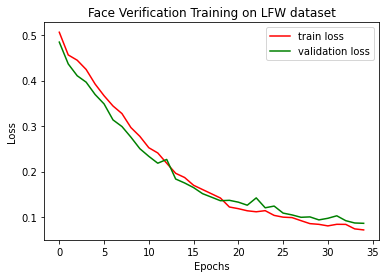

In [18]:
# Losses plot 
plt.plot(train_losses, color='r', label='train loss')
plt.plot(val_losses, color='g', label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Face Verification Training on LFW dataset")
plt.legend()
plt.show()

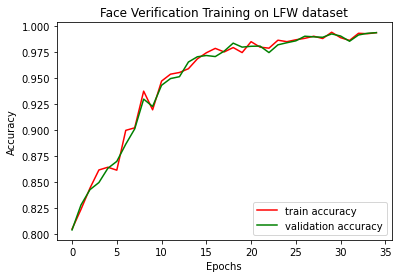

In [19]:
# Accuracy plot
plt.plot(train_accuracies, color='r', label='train accuracy')
plt.plot(val_accuracies, color='g', label='validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Face Verification Training on LFW dataset")
plt.legend()
plt.show()